# If you copy this notebook, please upvote !!

##  Market Prediction with Conv1d
It is assumed that there is a complex relationship between the features.

The relationship is clarified by spatial analysis.
### Refrence
Special thanks @Lonnie Ubiquant Market Prediction with DNN
https://www.kaggle.com/lonnieqin/ubiquant-market-prediction-with-dnn## 

### Note
- delete investment feature
- add random.set_seed

In [1]:
import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from scipy import stats
from tensorflow.python.ops import math_ops
from tensorflow.python.keras import backend as K

### add random seed
tf.random.set_seed(3)

## Configuration

In [2]:
class Config:
#     is_training = False
    is_training = True
    tf_record_dataset_path = "../input/ump-combinatorialpurgedgroupkfold-tf-record/"
    output_dataset_path = "../input/ump-conv-del-idx-outputs/"
config = Config()

## Create an IntegerLookup layer for investment_id input

In [3]:
%%time
investment_ids = pd.read_csv("../input/ump-combinatorialpurgedgroupkfold-tf-record/investment_ids.csv")
investment_id_size = len(investment_ids) + 1
with tf.device("cpu"):
    investment_id_lookup_layer = layers.IntegerLookup(max_tokens=investment_id_size)
    investment_id_lookup_layer.adapt(investment_ids)

2022-03-29 09:03:16.467689: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 09:03:16.565339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 09:03:16.565989: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 09:03:16.568201: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

CPU times: user 623 ms, sys: 371 ms, total: 994 ms
Wall time: 2.34 s


## Make Tensorflow dataset

In [4]:
def decode_function(record_bytes):
  return tf.io.parse_single_example(
      # Data
      record_bytes,
      # Schema
      {
          "features": tf.io.FixedLenFeature([300], dtype=tf.float32),
          "time_id": tf.io.FixedLenFeature([], dtype=tf.int64),
          "investment_id": tf.io.FixedLenFeature([], dtype=tf.int64),
          "target": tf.io.FixedLenFeature([], dtype=tf.float32)
      }
  )
def preprocess(item):
    return (item["features"]), item["target"]

def make_dataset(file_paths, batch_size=4096, mode="train"):
    ds = tf.data.TFRecordDataset(file_paths)
    ds = ds.map(decode_function)
    ds = ds.map(preprocess)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    return ds

## Modeling

I use layers.Conv1d. 

[source is here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)



In [5]:
def correlation(x, y, axis=-2):
    """Metric returning the Pearson correlation coefficient of two tensors over some axis, default -2."""
    x = tf.convert_to_tensor(x)
    y = math_ops.cast(y, x.dtype)
    n = tf.cast(tf.shape(x)[axis], x.dtype)
    xsum = tf.reduce_sum(x, axis=axis)
    ysum = tf.reduce_sum(y, axis=axis)
    xmean = xsum / n
    ymean = ysum / n
    
    xvar = tf.reduce_sum( tf.math.squared_difference(x, xmean), axis=axis)
    yvar = tf.reduce_sum( tf.math.squared_difference(y, ymean), axis=axis)

    cov = tf.reduce_sum( (x - xmean) * (y - ymean), axis=axis)
    corr = cov / tf.sqrt(xvar * yvar)
    return tf.constant(1.0, dtype=x.dtype) - corr

def get_model():
    features_inputs = tf.keras.Input((300, ), dtype=tf.float16)

    ## feature ##
    feature_x = layers.Dense(256, activation='swish')(features_inputs)
    feature_x = layers.Dropout(0.1)(feature_x)
    ## convolution 1 ##
    feature_x = layers.Reshape((-1,1))(feature_x)
    feature_x = layers.Conv1D(filters=16, kernel_size=4, strides=1, padding='same')(feature_x)
    feature_x = layers.BatchNormalization()(feature_x)
    feature_x = layers.LeakyReLU()(feature_x)
    ## convolution 2 ##
    feature_x = layers.Conv1D(filters=16, kernel_size=4, strides=4, padding='same')(feature_x)
    feature_x = layers.BatchNormalization()(feature_x)
    feature_x = layers.LeakyReLU()(feature_x)
    ## convolution 3 ##
    feature_x = layers.Conv1D(filters=64, kernel_size=4, strides=1, padding='same')(feature_x)
    feature_x = layers.BatchNormalization()(feature_x)
    feature_x = layers.LeakyReLU()(feature_x)
    ## convolution 4 ##
    feature_x = layers.Conv1D(filters=64, kernel_size=4, strides=4, padding='same')(feature_x)
    feature_x = layers.BatchNormalization()(feature_x)
    feature_x = layers.LeakyReLU()(feature_x)
    ## convolution 5 ##
    feature_x = layers.Conv1D(filters=64, kernel_size=4, strides=2, padding='same')(feature_x)
    feature_x = layers.BatchNormalization()(feature_x)
    feature_x = layers.LeakyReLU()(feature_x)
    ## flatten ##
    feature_x = layers.Flatten()(feature_x)
 
    x = layers.Dense(512, activation='swish', kernel_regularizer="l2")(feature_x)
    
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(128, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(32, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dropout(0.1)(x)
    output = layers.Dense(1)(x)
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")
    model = tf.keras.Model(inputs=[features_inputs], outputs=[output])
    model.compile(optimizer=tf.optimizers.Adam(0.001), loss='mse', metrics=['mse', "mae", "mape", rmse, correlation])
    return model

Let's take a look at this Model's architecture.

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               77056     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
reshape (Reshape)            (None, 256, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 256, 16)           80        
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 16)           64        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 16)           0     

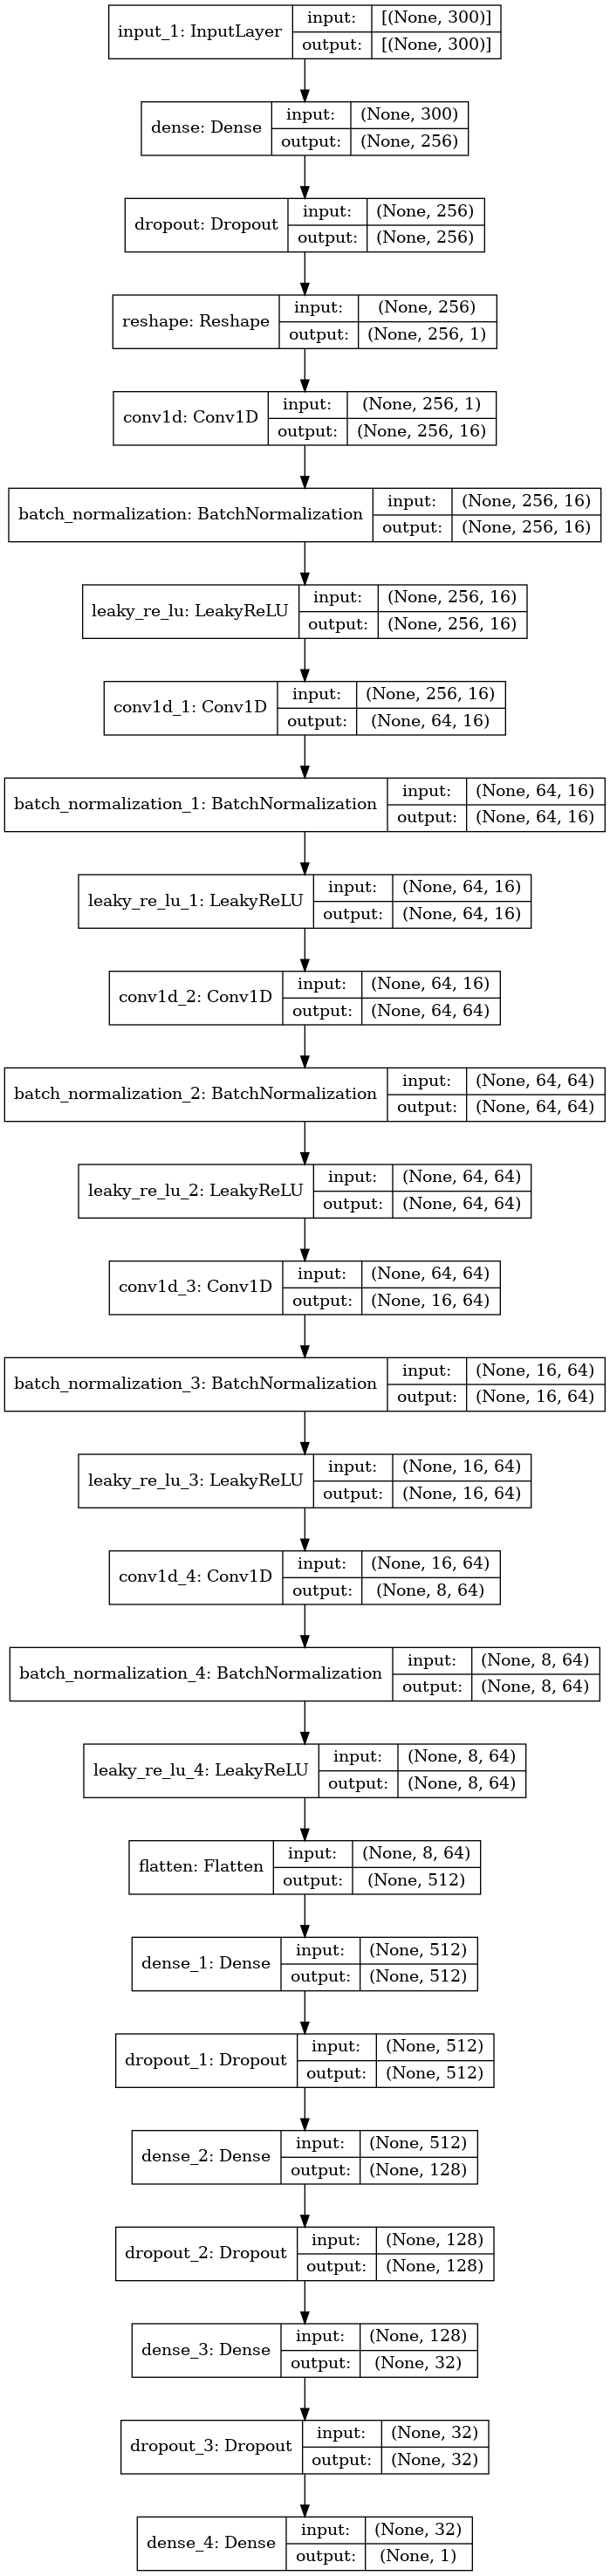

In [6]:
model = get_model()
model.summary()
keras.utils.plot_model(model, show_shapes=True)

## Model Training

<PrefetchDataset shapes: ((None, 300), (None,)), types: (tf.float32, tf.float32)>
Epoch 1/30


2022-03-29 09:03:24.992910: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


627/627 [==============================] - 184s 279ms/step - loss: 1.4785 - mse: 0.8355 - mae: 0.6253 - mape: 146820.5781 - rmse: 0.9141 - correlation: 0.8947 - val_loss: 0.8702 - val_mse: 0.8646 - val_mae: 0.6464 - val_mape: 53096.7188 - val_rmse: 0.9299 - val_correlation: 0.9179
Epoch 2/30
627/627 [==============================] - 48s 77ms/step - loss: 0.8327 - mse: 0.8280 - mae: 0.6223 - mape: 139629.3438 - rmse: 0.9099 - correlation: 0.8724 - val_loss: 0.8654 - val_mse: 0.8632 - val_mae: 0.6454 - val_mape: 82671.5234 - val_rmse: 0.9291 - val_correlation: 0.9170
Epoch 3/30
627/627 [==============================] - 48s 77ms/step - loss: 0.8302 - mse: 0.8258 - mae: 0.6216 - mape: 148813.2188 - rmse: 0.9087 - correlation: 0.8631 - val_loss: 0.8653 - val_mse: 0.8630 - val_mae: 0.6445 - val_mape: 108228.4141 - val_rmse: 0.9290 - val_correlation: 0.9172
Epoch 4/30
627/627 [==============================] - 48s 77ms/step - loss: 0.8288 - mse: 0.8241 - mae: 0.6210 - mape: 149633.5000 - rm

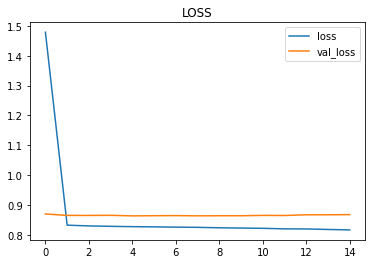

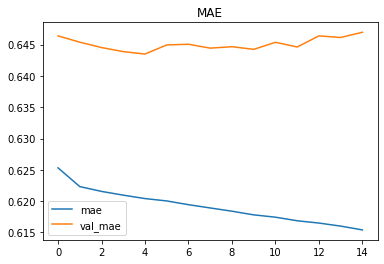

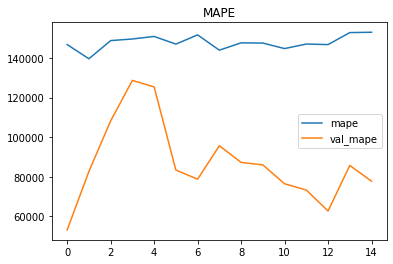

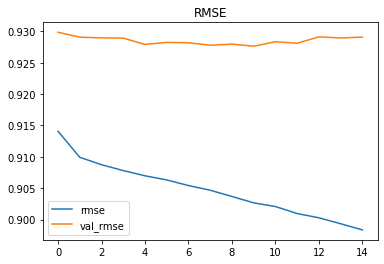

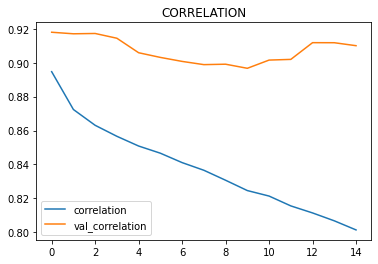

Pearson Score: 0.09050930108530601
<PrefetchDataset shapes: ((None, 300), (None,)), types: (tf.float32, tf.float32)>
Epoch 1/30
637/637 [==============================] - 187s 290ms/step - loss: 1.3532 - mse: 0.8460 - mae: 0.6218 - mape: 107851.3672 - rmse: 0.9198 - correlation: 0.8954 - val_loss: 0.8125 - val_mse: 0.8093 - val_mae: 0.6669 - val_mape: 32405.4102 - val_rmse: 0.8996 - val_correlation: 0.8927
Epoch 2/30
637/637 [==============================] - 49s 77ms/step - loss: 0.8456 - mse: 0.8417 - mae: 0.6204 - mape: 133746.0156 - rmse: 0.9174 - correlation: 0.8816 - val_loss: 0.8087 - val_mse: 0.8059 - val_mae: 0.6648 - val_mape: 58655.4570 - val_rmse: 0.8977 - val_correlation: 0.8916
Epoch 3/30
637/637 [==============================] - 49s 77ms/step - loss: 0.8438 - mse: 0.8394 - mae: 0.6196 - mape: 138336.8594 - rmse: 0.9162 - correlation: 0.8710 - val_loss: 0.8060 - val_mse: 0.8023 - val_mae: 0.6614 - val_mape: 115542.9609 - val_rmse: 0.8957 - val_correlation: 0.8862
Epoch 4

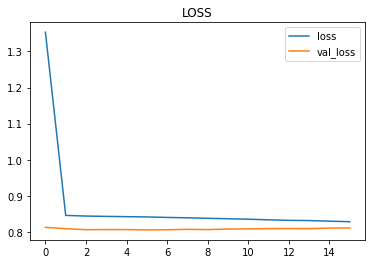

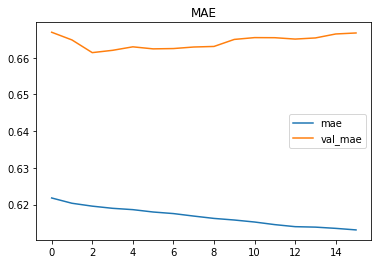

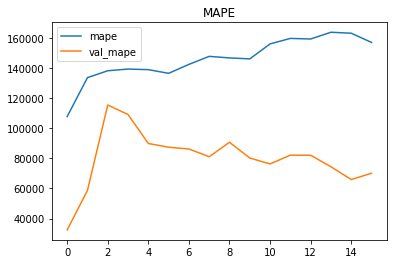

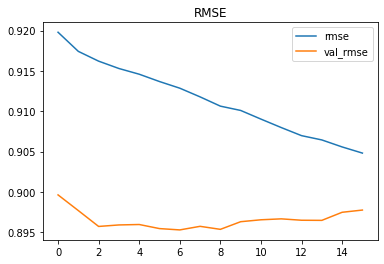

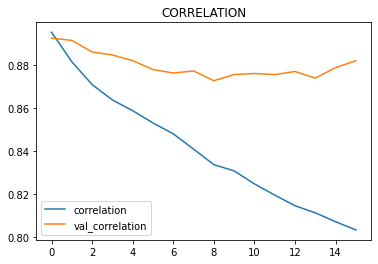

Pearson Score: 0.11774252165791074
<PrefetchDataset shapes: ((None, 300), (None,)), types: (tf.float32, tf.float32)>
Epoch 1/30
611/611 [==============================] - 192s 311ms/step - loss: 1.4406 - mse: 0.8385 - mae: 0.6288 - mape: 110094.4375 - rmse: 0.9157 - correlation: 0.8953 - val_loss: 0.8551 - val_mse: 0.8497 - val_mae: 0.6309 - val_mape: 70809.8594 - val_rmse: 0.9218 - val_correlation: 0.9020
Epoch 2/30
611/611 [==============================] - 47s 78ms/step - loss: 0.8379 - mse: 0.8330 - mae: 0.6270 - mape: 108657.3984 - rmse: 0.9127 - correlation: 0.8825 - val_loss: 0.8501 - val_mse: 0.8480 - val_mae: 0.6303 - val_mape: 104350.5469 - val_rmse: 0.9208 - val_correlation: 0.8983
Epoch 3/30
611/611 [==============================] - 47s 78ms/step - loss: 0.8349 - mse: 0.8304 - mae: 0.6260 - mape: 116147.8750 - rmse: 0.9113 - correlation: 0.8702 - val_loss: 0.8488 - val_mse: 0.8460 - val_mae: 0.6288 - val_mape: 167489.5781 - val_rmse: 0.9198 - val_correlation: 0.8984
Epoch 

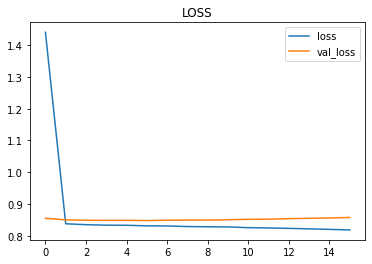

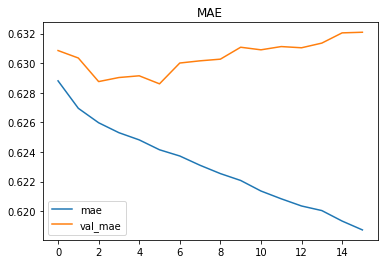

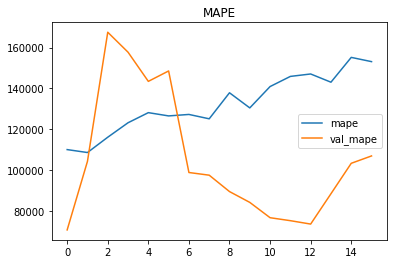

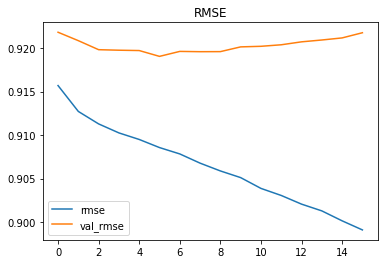

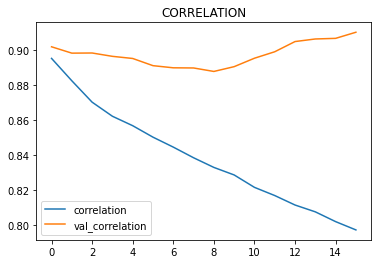

Pearson Score: 0.09005068079458625
<PrefetchDataset shapes: ((None, 300), (None,)), types: (tf.float32, tf.float32)>
Epoch 1/30
584/584 [==============================] - 184s 312ms/step - loss: 1.4472 - mse: 0.8297 - mae: 0.6285 - mape: 103289.9609 - rmse: 0.9109 - correlation: 0.8808 - val_loss: 0.8694 - val_mse: 0.8649 - val_mae: 0.6261 - val_mape: 152275.3125 - val_rmse: 0.9300 - val_correlation: 0.9115
Epoch 2/30
584/584 [==============================] - 46s 78ms/step - loss: 0.8291 - mse: 0.8241 - mae: 0.6264 - mape: 97497.5234 - rmse: 0.9078 - correlation: 0.8658 - val_loss: 0.8668 - val_mse: 0.8645 - val_mae: 0.6257 - val_mape: 171310.8281 - val_rmse: 0.9298 - val_correlation: 0.9125
Epoch 3/30
584/584 [==============================] - 45s 78ms/step - loss: 0.8263 - mse: 0.8216 - mae: 0.6254 - mape: 105308.0234 - rmse: 0.9064 - correlation: 0.8563 - val_loss: 0.8656 - val_mse: 0.8632 - val_mae: 0.6250 - val_mape: 228795.4688 - val_rmse: 0.9291 - val_correlation: 0.9087
Epoch 

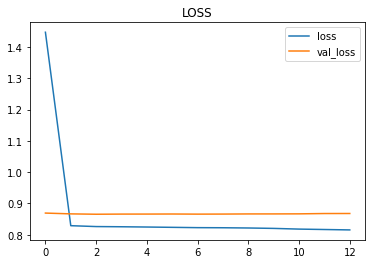

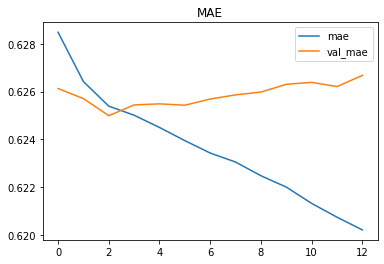

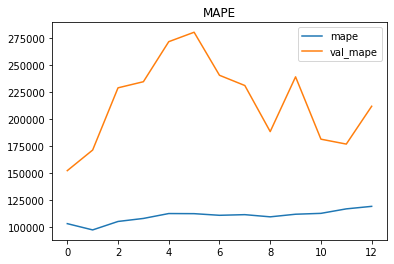

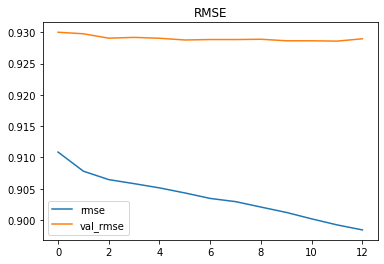

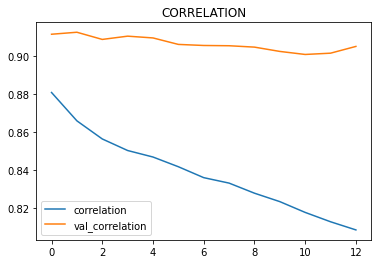

Pearson Score: 0.09633804387210419
<PrefetchDataset shapes: ((None, 300), (None,)), types: (tf.float32, tf.float32)>
Epoch 1/30
577/577 [==============================] - 178s 306ms/step - loss: 1.4041 - mse: 0.8470 - mae: 0.6357 - mape: 125113.6484 - rmse: 0.9203 - correlation: 0.8925 - val_loss: 0.8213 - val_mse: 0.8179 - val_mae: 0.6030 - val_mape: 30726.3750 - val_rmse: 0.9044 - val_correlation: 0.8940
Epoch 2/30
577/577 [==============================] - 45s 79ms/step - loss: 0.8457 - mse: 0.8409 - mae: 0.6334 - mape: 139241.8125 - rmse: 0.9170 - correlation: 0.8718 - val_loss: 0.8188 - val_mse: 0.8134 - val_mae: 0.6000 - val_mape: 193755.7031 - val_rmse: 0.9019 - val_correlation: 0.8793
Epoch 3/30
577/577 [==============================] - 45s 78ms/step - loss: 0.8437 - mse: 0.8385 - mae: 0.6325 - mape: 150170.1094 - rmse: 0.9157 - correlation: 0.8622 - val_loss: 0.8162 - val_mse: 0.8099 - val_mae: 0.6010 - val_mape: 130859.3438 - val_rmse: 0.9000 - val_correlation: 0.8763
Epoch 

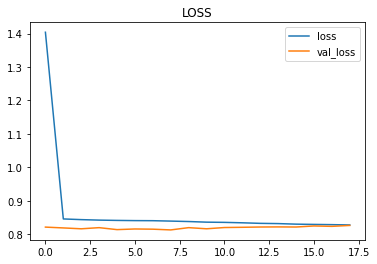

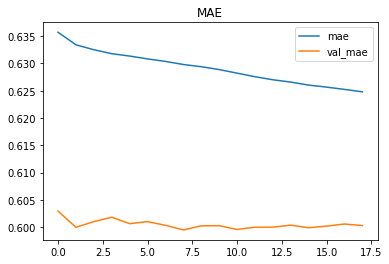

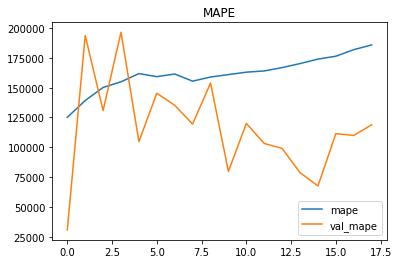

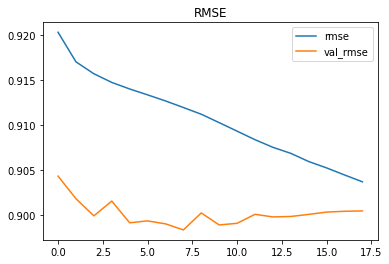

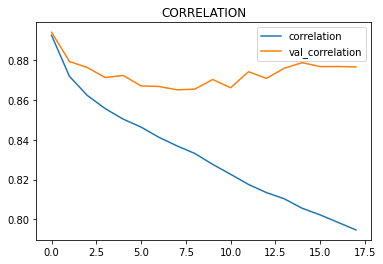

Pearson Score: 0.12436478464179015
CPU times: user 1h 7min 17s, sys: 7min 11s, total: 1h 14min 29s
Wall time: 1h 31min 49s


In [7]:
%%time
models = []
for i in range(5):
    train_path = f"{config.tf_record_dataset_path}fold_{i}_train.tfrecords"
    valid_path = f"{config.tf_record_dataset_path}fold_{i}_test.tfrecords"
    valid_ds = make_dataset([valid_path], mode="valid")
    print(valid_ds)
    model = get_model()
    if config.is_training:
        train_ds = make_dataset([train_path])
        checkpoint = keras.callbacks.ModelCheckpoint(f"model_{i}.tf", monitor="val_correlation", mode="min", save_best_only=True, save_weights_only=True)
        early_stop = keras.callbacks.EarlyStopping(patience=10)
        history = model.fit(train_ds, epochs=30, validation_data=valid_ds,shuffle=True, callbacks=[checkpoint, early_stop])
        model.save_weights(f"model_{i}.tf")
        for metric in ["loss", "mae", "mape", "rmse", "correlation"]:
            pd.DataFrame(history.history, columns=[metric, f"val_{metric}"]).plot()
            plt.title(metric.upper())
            plt.show()
    else:
        model.load_weights(f"{config.output_dataset_path}model_{i}.tf")
    y_vals = []
    for _, y in valid_ds:
        y_vals += list(y.numpy().reshape(-1))
    y_val = np.array(y_vals)
    pearson_score = stats.pearsonr(model.predict(valid_ds).reshape(-1), y_val)[0]
    models.append(model)
    print(f"Pearson Score: {pearson_score}")


## Submission

In [8]:
def make_test_dataset(feature, batch_size=1024):
    ds = tf.data.Dataset.from_tensor_slices(((feature)))
    ds = ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    return ds

def inference(models, ds):
    y_preds = []
    for model in models:
        y_pred = model.predict(ds)
        y_preds.append(y_pred)
    return np.mean(y_preds, axis=0)

In [9]:
import ubiquant
env = ubiquant.make_env()
iter_test = env.iter_test() 
features = [f"f_{i}" for i in range(300)]
for (test_df, sample_prediction_df) in iter_test:
    ds = make_test_dataset(test_df[features])
    sample_prediction_df['target'] = inference(models, ds)
    env.predict(sample_prediction_df)     
    

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
